In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
# from attention import Attention

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
dataset = pd.read_csv('../../data//pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [4]:
print(dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['pollution']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (43800, 1)
stages_supervised.shape: (43705, 96)


In [7]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
2010-01-05 01:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2010-01-05 02:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
2010-01-05 03:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
2010-01-05 04:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,164.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30 20:00:00,349.0,327.0,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
2014-12-30 21:00:00,327.0,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,264.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
2014-12-30 22:00:00,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,264.0,221.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0


#### Prior unknown covariates (6)

In [8]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [9]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [10]:
prior_known = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (43800, 10)
prior_known_supervised.shape: (43705, 960)


In [11]:
# prior_known_supervised

### N_out, N_in, K

In [12]:
past_cov = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (43705, 960)


In [13]:
# past_cov_supervised  # 6 + 9 = 15 features

In [14]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [15]:
# past_ws_supervised  # 4

In [16]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [17]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [18]:
# past_cov_ws_supervised

In [19]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23),shift_prior_known_supervised_var10(t+23)
0,-7.0,-6.0,1027.0,58.56,4.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-8.0,-6.0,1026.0,61.69,5.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-8.0,-7.0,1026.0,65.71,6.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-8.0,-7.0,1025.0,68.84,7.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-8.0,-7.0,1024.0,72.86,8.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-13.0,3.0,1017.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-13.0,1.0,1017.0,1.78,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-10.0,2.0,1017.0,2.67,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-10.0,-2.0,1017.0,3.12,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [21]:
# shift_prior_known_past_cov_ws_supervised

In [22]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
1,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
3,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
4,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,26.0,20.0,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43701,20.0,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43702,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,8.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43703,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,8.0,8.0,...,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Concatenation

In [23]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43705, 1536)


### Train & Test set

In [24]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 34964


In [25]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

1512

### Normalization

In [26]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (34964, 1512) (34964, 24) (8741, 1512) (8741, 24)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (34964, 72, 21) (34964, 24) (8741, 72, 21) (8741, 24)


### Model

In [34]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]), name='Bundled_Past_Future_inputs')
x = layers.SimpleRNN(208, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5),
                     return_sequences=True, name='SimpleRNN')(model_input)
x = layers.Flatten(name='Flatten_Layer')(x)
# x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
# x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-4, l2=1e-5))(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5), name='Dense1')(x)

output = layers.Dense(train_y.shape[1], name='Dense2')(x)

model_rnn = Model(model_input, output)
model_rnn.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bundled_Past_Future_inputs ( [(None, 72, 21)]          0         
_________________________________________________________________
SimpleRNN (SimpleRNN)        (None, 72, 208)           47840     
_________________________________________________________________
Flatten_Layer (Flatten)      (None, 14976)             0         
_________________________________________________________________
Dense1 (Dense)               (None, 64)                958528    
_________________________________________________________________
Dense2 (Dense)               (None, 24)                1560      
Total params: 1,007,928
Trainable params: 1,007,928
Non-trainable params: 0
_________________________________________________________________


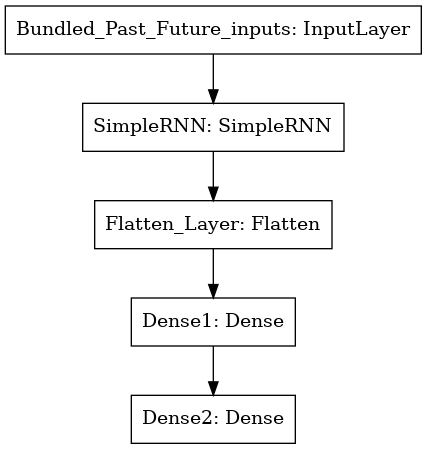

In [35]:
tf.keras.utils.plot_model(
    model_rnn,
#     to_file='model_rnn_plot_24.png',
    show_shapes=False,

    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
#     layer_range=None,
#     show_layer_activations=False
)

Epoch 1/3000

Epoch 00001: val_mae improved from inf to 0.11620, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0193 - mae: 0.0888 - val_loss: 0.0320 - val_mae: 0.1162
Epoch 2/3000

Epoch 00002: val_mae improved from 0.11620 to 0.11568, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0162 - mae: 0.0782 - val_loss: 0.0318 - val_mae: 0.1157
Epoch 3/3000

Epoch 00003: val_mae improved from 0.11568 to 0.11090, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0155 - mae: 0.0764 - val_loss: 0.0292 - val_mae: 0.1109
Epoch 4/3000

Epoch 00004: val_mae improved from 0.11090 to 0.11015, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0159 - mae: 0.0762 - val_loss: 0.0301 - val_mae: 0.1101
Epoch 5/3000

Epoch 00005: val_mae improved from 0.11015 to 0.09719, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0141 - mae: 0.0691 - val_loss: 0.0245 - val_mae: 0

Epoch 49/3000

Epoch 00049: val_mae did not improve from 0.06328
69/69 - 3s - loss: 0.0061 - mae: 0.0457 - val_loss: 0.0109 - val_mae: 0.0703
Epoch 50/3000

Epoch 00050: val_mae improved from 0.06328 to 0.06240, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0059 - mae: 0.0447 - val_loss: 0.0103 - val_mae: 0.0624
Epoch 51/3000

Epoch 00051: val_mae did not improve from 0.06240
69/69 - 2s - loss: 0.0057 - mae: 0.0434 - val_loss: 0.0107 - val_mae: 0.0657
Epoch 52/3000

Epoch 00052: val_mae did not improve from 0.06240
69/69 - 3s - loss: 0.0067 - mae: 0.0496 - val_loss: 0.0108 - val_mae: 0.0694
Epoch 53/3000

Epoch 00053: val_mae did not improve from 0.06240
69/69 - 3s - loss: 0.0058 - mae: 0.0444 - val_loss: 0.0102 - val_mae: 0.0626
Epoch 54/3000

Epoch 00054: val_mae did not improve from 0.06240
69/69 - 3s - loss: 0.0055 - mae: 0.0428 - val_loss: 0.0103 - val_mae: 0.0652
Epoch 55/3000

Epoch 00055: val_mae did not improve from 0.06240
69/69 - 3s - loss: 0.0

Epoch 102/3000

Epoch 00102: val_mae did not improve from 0.05734
69/69 - 3s - loss: 0.0043 - mae: 0.0388 - val_loss: 0.0086 - val_mae: 0.0599
Epoch 103/3000

Epoch 00103: val_mae did not improve from 0.05734
69/69 - 3s - loss: 0.0046 - mae: 0.0408 - val_loss: 0.0082 - val_mae: 0.0591
Epoch 104/3000

Epoch 00104: val_mae improved from 0.05734 to 0.05732, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0043 - mae: 0.0391 - val_loss: 0.0084 - val_mae: 0.0573
Epoch 105/3000

Epoch 00105: val_mae did not improve from 0.05732
69/69 - 3s - loss: 0.0042 - mae: 0.0388 - val_loss: 0.0085 - val_mae: 0.0600
Epoch 106/3000

Epoch 00106: val_mae did not improve from 0.05732
69/69 - 3s - loss: 0.0045 - mae: 0.0404 - val_loss: 0.0081 - val_mae: 0.0585
Epoch 107/3000

Epoch 00107: val_mae improved from 0.05732 to 0.05712, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0042 - mae: 0.0388 - val_loss: 0.0083 - val_mae: 0.0571
Epoch 108/3000

Epoc

Epoch 155/3000

Epoch 00155: val_mae did not improve from 0.05601
69/69 - 3s - loss: 0.0037 - mae: 0.0372 - val_loss: 0.0078 - val_mae: 0.0561
Epoch 156/3000

Epoch 00156: val_mae did not improve from 0.05601
69/69 - 2s - loss: 0.0037 - mae: 0.0372 - val_loss: 0.0078 - val_mae: 0.0578
Epoch 157/3000

Epoch 00157: val_mae improved from 0.05601 to 0.05573, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0038 - mae: 0.0379 - val_loss: 0.0074 - val_mae: 0.0557
Epoch 158/3000

Epoch 00158: val_mae did not improve from 0.05573
69/69 - 3s - loss: 0.0037 - mae: 0.0369 - val_loss: 0.0078 - val_mae: 0.0560
Epoch 159/3000

Epoch 00159: val_mae did not improve from 0.05573
69/69 - 3s - loss: 0.0037 - mae: 0.0371 - val_loss: 0.0078 - val_mae: 0.0578
Epoch 160/3000

Epoch 00160: val_mae did not improve from 0.05573
69/69 - 3s - loss: 0.0038 - mae: 0.0380 - val_loss: 0.0074 - val_mae: 0.0558
Epoch 161/3000

Epoch 00161: val_mae did not improve from 0.05573
69/69 - 3s - lo


Epoch 00208: val_mae did not improve from 0.05435
69/69 - 3s - loss: 0.0035 - mae: 0.0367 - val_loss: 0.0071 - val_mae: 0.0544
Epoch 209/3000

Epoch 00209: val_mae did not improve from 0.05435
69/69 - 3s - loss: 0.0034 - mae: 0.0357 - val_loss: 0.0075 - val_mae: 0.0554
Epoch 210/3000

Epoch 00210: val_mae did not improve from 0.05435
69/69 - 3s - loss: 0.0034 - mae: 0.0360 - val_loss: 0.0075 - val_mae: 0.0570
Epoch 211/3000

Epoch 00211: val_mae improved from 0.05435 to 0.05413, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0035 - mae: 0.0365 - val_loss: 0.0070 - val_mae: 0.0541
Epoch 212/3000

Epoch 00212: val_mae did not improve from 0.05413
69/69 - 3s - loss: 0.0033 - mae: 0.0355 - val_loss: 0.0075 - val_mae: 0.0553
Epoch 213/3000

Epoch 00213: val_mae did not improve from 0.05413
69/69 - 3s - loss: 0.0034 - mae: 0.0360 - val_loss: 0.0075 - val_mae: 0.0569
Epoch 214/3000

Epoch 00214: val_mae improved from 0.05413 to 0.05403, saving model to saved_mod

Epoch 260/3000

Epoch 00260: val_mae did not improve from 0.05267
69/69 - 3s - loss: 0.0032 - mae: 0.0350 - val_loss: 0.0074 - val_mae: 0.0563
Epoch 261/3000

Epoch 00261: val_mae did not improve from 0.05267
69/69 - 2s - loss: 0.0034 - mae: 0.0362 - val_loss: 0.0070 - val_mae: 0.0541
Epoch 262/3000

Epoch 00262: val_mae did not improve from 0.05267
69/69 - 3s - loss: 0.0032 - mae: 0.0351 - val_loss: 0.0073 - val_mae: 0.0550
Epoch 263/3000

Epoch 00263: val_mae did not improve from 0.05267
69/69 - 3s - loss: 0.0032 - mae: 0.0353 - val_loss: 0.0073 - val_mae: 0.0562
Epoch 264/3000

Epoch 00264: val_mae did not improve from 0.05267
69/69 - 3s - loss: 0.0031 - mae: 0.0343 - val_loss: 0.0068 - val_mae: 0.0530
Epoch 265/3000

Epoch 00265: val_mae did not improve from 0.05267
69/69 - 3s - loss: 0.0031 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0546
Epoch 266/3000

Epoch 00266: val_mae did not improve from 0.05267
69/69 - 3s - loss: 0.0032 - mae: 0.0350 - val_loss: 0.0073 - val_mae: 0.0566

Epoch 314/3000

Epoch 00314: val_mae did not improve from 0.05235
69/69 - 3s - loss: 0.0032 - mae: 0.0352 - val_loss: 0.0073 - val_mae: 0.0569
Epoch 315/3000

Epoch 00315: val_mae did not improve from 0.05235
69/69 - 3s - loss: 0.0030 - mae: 0.0340 - val_loss: 0.0068 - val_mae: 0.0524
Epoch 316/3000

Epoch 00316: val_mae did not improve from 0.05235
69/69 - 3s - loss: 0.0030 - mae: 0.0334 - val_loss: 0.0073 - val_mae: 0.0550
Epoch 317/3000

Epoch 00317: val_mae did not improve from 0.05235
69/69 - 3s - loss: 0.0032 - mae: 0.0352 - val_loss: 0.0073 - val_mae: 0.0570
Epoch 318/3000

Epoch 00318: val_mae improved from 0.05235 to 0.05231, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0030 - mae: 0.0340 - val_loss: 0.0068 - val_mae: 0.0523
Epoch 319/3000

Epoch 00319: val_mae did not improve from 0.05231
69/69 - 3s - loss: 0.0030 - mae: 0.0333 - val_loss: 0.0073 - val_mae: 0.0550
Epoch 320/3000

Epoch 00320: val_mae did not improve from 0.05231
69/69 - 3s - lo

Epoch 370/3000

Epoch 00370: val_mae did not improve from 0.05210
69/69 - 3s - loss: 0.0031 - mae: 0.0349 - val_loss: 0.0071 - val_mae: 0.0564
Epoch 371/3000

Epoch 00371: val_mae did not improve from 0.05210
69/69 - 3s - loss: 0.0029 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0524
Epoch 372/3000

Epoch 00372: val_mae did not improve from 0.05210
69/69 - 3s - loss: 0.0029 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0542
Epoch 373/3000

Epoch 00373: val_mae did not improve from 0.05210
69/69 - 3s - loss: 0.0032 - mae: 0.0352 - val_loss: 0.0068 - val_mae: 0.0541
Epoch 374/3000

Epoch 00374: val_mae did not improve from 0.05210
69/69 - 3s - loss: 0.0030 - mae: 0.0341 - val_loss: 0.0072 - val_mae: 0.0545
Epoch 375/3000

Epoch 00375: val_mae did not improve from 0.05210
69/69 - 3s - loss: 0.0030 - mae: 0.0340 - val_loss: 0.0071 - val_mae: 0.0556
Epoch 376/3000

Epoch 00376: val_mae did not improve from 0.05210
69/69 - 3s - loss: 0.0029 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0524

Epoch 426/3000

Epoch 00426: val_mae did not improve from 0.05188
69/69 - 3s - loss: 0.0029 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0537
Epoch 427/3000

Epoch 00427: val_mae did not improve from 0.05188
69/69 - 2s - loss: 0.0029 - mae: 0.0334 - val_loss: 0.0070 - val_mae: 0.0550
Epoch 428/3000

Epoch 00428: val_mae improved from 0.05188 to 0.05184, saving model to saved_model/rnn_shift_anyday_24h_cp3.h5
69/69 - 3s - loss: 0.0027 - mae: 0.0320 - val_loss: 0.0068 - val_mae: 0.0518
Epoch 429/3000

Epoch 00429: val_mae did not improve from 0.05184
69/69 - 3s - loss: 0.0027 - mae: 0.0318 - val_loss: 0.0070 - val_mae: 0.0537
Epoch 430/3000

Epoch 00430: val_mae did not improve from 0.05184
69/69 - 3s - loss: 0.0031 - mae: 0.0349 - val_loss: 0.0068 - val_mae: 0.0544
Epoch 431/3000

Epoch 00431: val_mae did not improve from 0.05184
69/69 - 3s - loss: 0.0029 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0541
Epoch 432/3000

Epoch 00432: val_mae did not improve from 0.05184
69/69 - 3s - lo

Epoch 483/3000

Epoch 00483: val_mae did not improve from 0.05167
69/69 - 3s - loss: 0.0028 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0537
Epoch 484/3000

Epoch 00484: val_mae did not improve from 0.05167
69/69 - 3s - loss: 0.0028 - mae: 0.0327 - val_loss: 0.0072 - val_mae: 0.0556
Epoch 485/3000

Epoch 00485: val_mae did not improve from 0.05167
69/69 - 3s - loss: 0.0028 - mae: 0.0322 - val_loss: 0.0067 - val_mae: 0.0520
Epoch 486/3000

Epoch 00486: val_mae did not improve from 0.05167
69/69 - 3s - loss: 0.0028 - mae: 0.0326 - val_loss: 0.0073 - val_mae: 0.0550
Epoch 487/3000

Epoch 00487: val_mae did not improve from 0.05167
69/69 - 2s - loss: 0.0030 - mae: 0.0341 - val_loss: 0.0070 - val_mae: 0.0544
Epoch 488/3000

Epoch 00488: val_mae did not improve from 0.05167
69/69 - 3s - loss: 0.0027 - mae: 0.0316 - val_loss: 0.0068 - val_mae: 0.0523
Epoch 489/3000

Epoch 00489: val_mae did not improve from 0.05167
69/69 - 3s - loss: 0.0027 - mae: 0.0316 - val_loss: 0.0070 - val_mae: 0.0535

Epoch 540/3000

Epoch 00540: val_mae did not improve from 0.05160
69/69 - 3s - loss: 0.0027 - mae: 0.0321 - val_loss: 0.0069 - val_mae: 0.0527
Epoch 541/3000

Epoch 00541: val_mae did not improve from 0.05160
69/69 - 3s - loss: 0.0027 - mae: 0.0320 - val_loss: 0.0071 - val_mae: 0.0544
Epoch 542/3000

Epoch 00542: val_mae did not improve from 0.05160
69/69 - 3s - loss: 0.0030 - mae: 0.0345 - val_loss: 0.0066 - val_mae: 0.0518
Epoch 543/3000

Epoch 00543: val_mae did not improve from 0.05160
69/69 - 3s - loss: 0.0027 - mae: 0.0321 - val_loss: 0.0071 - val_mae: 0.0537
Epoch 544/3000

Epoch 00544: val_mae did not improve from 0.05160
69/69 - 3s - loss: 0.0028 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0542
Epoch 545/3000

Epoch 00545: val_mae did not improve from 0.05160
69/69 - 3s - loss: 0.0026 - mae: 0.0314 - val_loss: 0.0069 - val_mae: 0.0525
Epoch 546/3000

Epoch 00546: val_mae did not improve from 0.05160
69/69 - 3s - loss: 0.0027 - mae: 0.0316 - val_loss: 0.0071 - val_mae: 0.0544

Epoch 597/3000

Epoch 00597: val_mae did not improve from 0.05109
69/69 - 3s - loss: 0.0029 - mae: 0.0336 - val_loss: 0.0068 - val_mae: 0.0531
Epoch 598/3000

Epoch 00598: val_mae did not improve from 0.05109
69/69 - 3s - loss: 0.0026 - mae: 0.0308 - val_loss: 0.0070 - val_mae: 0.0525
Epoch 599/3000

Epoch 00599: val_mae did not improve from 0.05109
69/69 - 3s - loss: 0.0027 - mae: 0.0315 - val_loss: 0.0070 - val_mae: 0.0535
Epoch 600/3000

Epoch 00600: val_mae did not improve from 0.05109
69/69 - 3s - loss: 0.0027 - mae: 0.0324 - val_loss: 0.0072 - val_mae: 0.0544
Epoch 601/3000

Epoch 00601: val_mae did not improve from 0.05109
69/69 - 3s - loss: 0.0027 - mae: 0.0319 - val_loss: 0.0069 - val_mae: 0.0528
Epoch 602/3000

Epoch 00602: val_mae did not improve from 0.05109
69/69 - 3s - loss: 0.0025 - mae: 0.0307 - val_loss: 0.0070 - val_mae: 0.0535
Epoch 603/3000

Epoch 00603: val_mae did not improve from 0.05109
69/69 - 3s - loss: 0.0026 - mae: 0.0311 - val_loss: 0.0069 - val_mae: 0.0538

Epoch 654/3000

Epoch 00654: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0026 - mae: 0.0316 - val_loss: 0.0068 - val_mae: 0.0518
Epoch 655/3000

Epoch 00655: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0026 - mae: 0.0311 - val_loss: 0.0070 - val_mae: 0.0534
Epoch 656/3000

Epoch 00656: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0029 - mae: 0.0333 - val_loss: 0.0065 - val_mae: 0.0514
Epoch 657/3000

Epoch 00657: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0026 - mae: 0.0314 - val_loss: 0.0071 - val_mae: 0.0536
Epoch 658/3000

Epoch 00658: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0028 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0533
Epoch 659/3000

Epoch 00659: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0026 - mae: 0.0310 - val_loss: 0.0070 - val_mae: 0.0532
Epoch 660/3000

Epoch 00660: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0026 - mae: 0.0316 - val_loss: 0.0072 - val_mae: 0.0553

Epoch 712/3000

Epoch 00712: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0025 - mae: 0.0307 - val_loss: 0.0067 - val_mae: 0.0514
Epoch 713/3000

Epoch 00713: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0025 - mae: 0.0304 - val_loss: 0.0070 - val_mae: 0.0533
Epoch 714/3000

Epoch 00714: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0029 - mae: 0.0340 - val_loss: 0.0066 - val_mae: 0.0521
Epoch 715/3000

Epoch 00715: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0026 - mae: 0.0318 - val_loss: 0.0071 - val_mae: 0.0534
Epoch 716/3000

Epoch 00716: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0027 - mae: 0.0322 - val_loss: 0.0067 - val_mae: 0.0529
Epoch 717/3000

Epoch 00717: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0025 - mae: 0.0304 - val_loss: 0.0070 - val_mae: 0.0526
Epoch 718/3000

Epoch 00718: val_mae did not improve from 0.05090
69/69 - 3s - loss: 0.0026 - mae: 0.0309 - val_loss: 0.0071 - val_mae: 0.0546

Epoch 769/3000

Epoch 00769: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0027 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0538
Epoch 770/3000

Epoch 00770: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0025 - mae: 0.0303 - val_loss: 0.0070 - val_mae: 0.0525
Epoch 771/3000

Epoch 00771: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0025 - mae: 0.0305 - val_loss: 0.0071 - val_mae: 0.0541
Epoch 772/3000

Epoch 00772: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0027 - mae: 0.0323 - val_loss: 0.0066 - val_mae: 0.0519
Epoch 773/3000

Epoch 00773: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0027 - mae: 0.0320 - val_loss: 0.0072 - val_mae: 0.0544
Epoch 774/3000

Epoch 00774: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0028 - mae: 0.0333 - val_loss: 0.0066 - val_mae: 0.0518
Epoch 775/3000

Epoch 00775: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0026 - mae: 0.0310 - val_loss: 0.0072 - val_mae: 0.0536

Epoch 827/3000

Epoch 00827: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0024 - mae: 0.0296 - val_loss: 0.0069 - val_mae: 0.0527
Epoch 828/3000

Epoch 00828: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0027 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0534
Epoch 829/3000

Epoch 00829: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0025 - mae: 0.0312 - val_loss: 0.0070 - val_mae: 0.0529
Epoch 830/3000

Epoch 00830: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0025 - mae: 0.0306 - val_loss: 0.0072 - val_mae: 0.0543
Epoch 831/3000

Epoch 00831: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0025 - mae: 0.0304 - val_loss: 0.0066 - val_mae: 0.0509
Epoch 832/3000

Epoch 00832: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0026 - mae: 0.0311 - val_loss: 0.0072 - val_mae: 0.0537
Epoch 833/3000

Epoch 00833: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0029 - mae: 0.0337 - val_loss: 0.0067 - val_mae: 0.0511

Epoch 885/3000

Epoch 00885: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0025 - mae: 0.0308 - val_loss: 0.0071 - val_mae: 0.0543
Epoch 886/3000

Epoch 00886: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0024 - mae: 0.0298 - val_loss: 0.0068 - val_mae: 0.0515
Epoch 887/3000

Epoch 00887: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0024 - mae: 0.0296 - val_loss: 0.0070 - val_mae: 0.0528
Epoch 888/3000

Epoch 00888: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0027 - mae: 0.0321 - val_loss: 0.0067 - val_mae: 0.0531
Epoch 889/3000

Epoch 00889: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0024 - mae: 0.0302 - val_loss: 0.0071 - val_mae: 0.0532
Epoch 890/3000

Epoch 00890: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0025 - mae: 0.0306 - val_loss: 0.0072 - val_mae: 0.0553
Epoch 891/3000

Epoch 00891: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0025 - mae: 0.0302 - val_loss: 0.0067 - val_mae: 0.0510

Epoch 943/3000

Epoch 00943: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0025 - mae: 0.0308 - val_loss: 0.0069 - val_mae: 0.0534
Epoch 944/3000

Epoch 00944: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0024 - mae: 0.0297 - val_loss: 0.0069 - val_mae: 0.0522
Epoch 945/3000

Epoch 00945: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0024 - mae: 0.0294 - val_loss: 0.0071 - val_mae: 0.0532
Epoch 946/3000

Epoch 00946: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0025 - mae: 0.0304 - val_loss: 0.0066 - val_mae: 0.0514
Epoch 947/3000

Epoch 00947: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0025 - mae: 0.0302 - val_loss: 0.0071 - val_mae: 0.0529
Epoch 948/3000

Epoch 00948: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0026 - mae: 0.0312 - val_loss: 0.0068 - val_mae: 0.0523
Epoch 949/3000

Epoch 00949: val_mae did not improve from 0.05060
69/69 - 2s - loss: 0.0024 - mae: 0.0300 - val_loss: 0.0070 - val_mae: 0.0521

Epoch 1001/3000

Epoch 01001: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0026 - mae: 0.0319 - val_loss: 0.0072 - val_mae: 0.0554
Epoch 1002/3000

Epoch 01002: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0025 - mae: 0.0304 - val_loss: 0.0067 - val_mae: 0.0512
Epoch 1003/3000

Epoch 01003: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0025 - mae: 0.0305 - val_loss: 0.0072 - val_mae: 0.0541
Epoch 1004/3000

Epoch 01004: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0028 - mae: 0.0331 - val_loss: 0.0067 - val_mae: 0.0527
Epoch 1005/3000

Epoch 01005: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0023 - mae: 0.0294 - val_loss: 0.0070 - val_mae: 0.0526
Epoch 1006/3000

Epoch 01006: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0025 - mae: 0.0303 - val_loss: 0.0073 - val_mae: 0.0550
Epoch 1007/3000

Epoch 01007: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0024 - mae: 0.0302 - val_loss: 0.0067 - val_mae:

Epoch 1058/3000

Epoch 01058: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0024 - mae: 0.0295 - val_loss: 0.0069 - val_mae: 0.0524
Epoch 1059/3000

Epoch 01059: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0025 - mae: 0.0303 - val_loss: 0.0068 - val_mae: 0.0520
Epoch 1060/3000

Epoch 01060: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0024 - mae: 0.0298 - val_loss: 0.0070 - val_mae: 0.0526
Epoch 1061/3000

Epoch 01061: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0069 - val_mae: 0.0525
Epoch 1062/3000

Epoch 01062: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0024 - mae: 0.0300 - val_loss: 0.0073 - val_mae: 0.0543
Epoch 1063/3000

Epoch 01063: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0024 - mae: 0.0302 - val_loss: 0.0066 - val_mae: 0.0507
Epoch 1064/3000

Epoch 01064: val_mae did not improve from 0.05060
69/69 - 3s - loss: 0.0024 - mae: 0.0299 - val_loss: 0.0068 - val_mae:

Epoch 1115/3000

Epoch 01115: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0070 - val_mae: 0.0526
Epoch 1116/3000

Epoch 01116: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0310 - val_loss: 0.0065 - val_mae: 0.0507
Epoch 1117/3000

Epoch 01117: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0300 - val_loss: 0.0070 - val_mae: 0.0526
Epoch 1118/3000

Epoch 01118: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0310 - val_loss: 0.0065 - val_mae: 0.0507
Epoch 1119/3000

Epoch 01119: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0300 - val_loss: 0.0070 - val_mae: 0.0526
Epoch 1120/3000

Epoch 01120: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0311 - val_loss: 0.0065 - val_mae: 0.0507
Epoch 1121/3000

Epoch 01121: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0070 - val_mae:

Epoch 1172/3000

Epoch 01172: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0296 - val_loss: 0.0071 - val_mae: 0.0531
Epoch 1173/3000

Epoch 01173: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0310 - val_loss: 0.0068 - val_mae: 0.0522
Epoch 1174/3000

Epoch 01174: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0070 - val_mae: 0.0526
Epoch 1175/3000

Epoch 01175: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0071 - val_mae: 0.0537
Epoch 1176/3000

Epoch 01176: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0297 - val_loss: 0.0068 - val_mae: 0.0513
Epoch 1177/3000

Epoch 01177: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0291 - val_loss: 0.0069 - val_mae: 0.0521
Epoch 1178/3000

Epoch 01178: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0306 - val_loss: 0.0067 - val_mae:

Epoch 1229/3000

Epoch 01229: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0070 - val_mae: 0.0527
Epoch 1230/3000

Epoch 01230: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0311 - val_loss: 0.0067 - val_mae: 0.0512
Epoch 1231/3000

Epoch 01231: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0070 - val_mae: 0.0527
Epoch 1232/3000

Epoch 01232: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0309 - val_loss: 0.0067 - val_mae: 0.0511
Epoch 1233/3000

Epoch 01233: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0070 - val_mae: 0.0527
Epoch 1234/3000

Epoch 01234: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0309 - val_loss: 0.0067 - val_mae: 0.0510
Epoch 1235/3000

Epoch 01235: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0070 - val_mae:

Epoch 1286/3000

Epoch 01286: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0308 - val_loss: 0.0067 - val_mae: 0.0509
Epoch 1287/3000

Epoch 01287: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0299 - val_loss: 0.0072 - val_mae: 0.0535
Epoch 1288/3000

Epoch 01288: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0307 - val_loss: 0.0067 - val_mae: 0.0510
Epoch 1289/3000

Epoch 01289: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0297 - val_loss: 0.0071 - val_mae: 0.0534
Epoch 1290/3000

Epoch 01290: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0309 - val_loss: 0.0066 - val_mae: 0.0509
Epoch 1291/3000

Epoch 01291: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0298 - val_loss: 0.0072 - val_mae: 0.0535
Epoch 1292/3000

Epoch 01292: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0309 - val_loss: 0.0067 - val_mae:

Epoch 1343/3000

Epoch 01343: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0307 - val_loss: 0.0069 - val_mae: 0.0523
Epoch 1344/3000

Epoch 01344: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0296 - val_loss: 0.0071 - val_mae: 0.0529
Epoch 1345/3000

Epoch 01345: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0298 - val_loss: 0.0069 - val_mae: 0.0525
Epoch 1346/3000

Epoch 01346: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0292 - val_loss: 0.0073 - val_mae: 0.0537
Epoch 1347/3000

Epoch 01347: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0295 - val_loss: 0.0068 - val_mae: 0.0518
Epoch 1348/3000

Epoch 01348: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0070 - val_mae: 0.0523
Epoch 1349/3000

Epoch 01349: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0070 - val_mae:

Epoch 1400/3000

Epoch 01400: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0305 - val_loss: 0.0067 - val_mae: 0.0513
Epoch 1401/3000

Epoch 01401: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0297 - val_loss: 0.0072 - val_mae: 0.0538
Epoch 1402/3000

Epoch 01402: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0305 - val_loss: 0.0067 - val_mae: 0.0513
Epoch 1403/3000

Epoch 01403: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0297 - val_loss: 0.0072 - val_mae: 0.0537
Epoch 1404/3000

Epoch 01404: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0305 - val_loss: 0.0067 - val_mae: 0.0513
Epoch 1405/3000

Epoch 01405: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0297 - val_loss: 0.0072 - val_mae: 0.0537
Epoch 1406/3000

Epoch 01406: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0025 - mae: 0.0307 - val_loss: 0.0067 - val_mae:

Epoch 1457/3000

Epoch 01457: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0299 - val_loss: 0.0073 - val_mae: 0.0545
Epoch 1458/3000

Epoch 01458: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0068 - val_mae: 0.0515
Epoch 1459/3000

Epoch 01459: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0069 - val_mae: 0.0525
Epoch 1460/3000

Epoch 01460: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0026 - mae: 0.0319 - val_loss: 0.0069 - val_mae: 0.0527
Epoch 1461/3000

Epoch 01461: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0023 - mae: 0.0296 - val_loss: 0.0071 - val_mae: 0.0532
Epoch 1462/3000

Epoch 01462: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0024 - mae: 0.0301 - val_loss: 0.0070 - val_mae: 0.0532
Epoch 1463/3000

Epoch 01463: val_mae did not improve from 0.05039
69/69 - 3s - loss: 0.0022 - mae: 0.0289 - val_loss: 0.0069 - val_mae:

Epoch 1514/3000

Epoch 01514: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0072 - val_mae: 0.0534
Epoch 1515/3000

Epoch 01515: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0024 - mae: 0.0304 - val_loss: 0.0067 - val_mae: 0.0513
Epoch 1516/3000

Epoch 01516: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0294 - val_loss: 0.0072 - val_mae: 0.0535
Epoch 1517/3000

Epoch 01517: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0024 - mae: 0.0306 - val_loss: 0.0067 - val_mae: 0.0513
Epoch 1518/3000

Epoch 01518: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0294 - val_loss: 0.0072 - val_mae: 0.0534
Epoch 1519/3000

Epoch 01519: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0024 - mae: 0.0304 - val_loss: 0.0067 - val_mae: 0.0514
Epoch 1520/3000

Epoch 01520: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0292 - val_loss: 0.0072 - val_mae:

Epoch 1571/3000

Epoch 01571: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0024 - mae: 0.0300 - val_loss: 0.0069 - val_mae: 0.0529
Epoch 1572/3000

Epoch 01572: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0072 - val_mae: 0.0538
Epoch 1573/3000

Epoch 01573: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0024 - mae: 0.0305 - val_loss: 0.0069 - val_mae: 0.0526
Epoch 1574/3000

Epoch 01574: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0071 - val_mae: 0.0531
Epoch 1575/3000

Epoch 01575: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0297 - val_loss: 0.0072 - val_mae: 0.0535
Epoch 1576/3000

Epoch 01576: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0068 - val_mae: 0.0518
Epoch 1577/3000

Epoch 01577: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0071 - val_mae:

Epoch 1628/3000

Epoch 01628: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0294 - val_loss: 0.0072 - val_mae: 0.0534
Epoch 1629/3000

Epoch 01629: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0024 - mae: 0.0305 - val_loss: 0.0067 - val_mae: 0.0512
Epoch 1630/3000

Epoch 01630: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0294 - val_loss: 0.0072 - val_mae: 0.0533
Epoch 1631/3000

Epoch 01631: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0024 - mae: 0.0303 - val_loss: 0.0067 - val_mae: 0.0513
Epoch 1632/3000

Epoch 01632: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0072 - val_mae: 0.0534
Epoch 1633/3000

Epoch 01633: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0024 - mae: 0.0304 - val_loss: 0.0067 - val_mae: 0.0512
Epoch 1634/3000

Epoch 01634: val_mae did not improve from 0.05028
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0072 - val_mae:

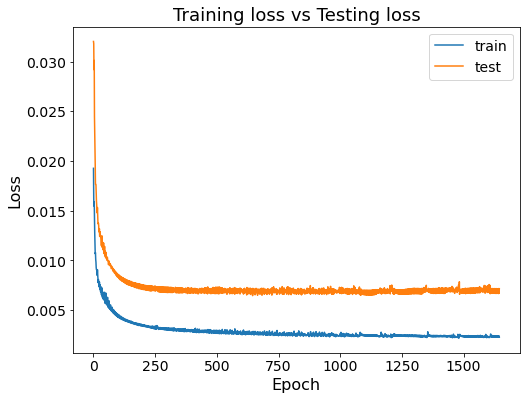

In [46]:
lr = 0.0001
EPOCHS = 3000

# initial_learning_rate * decay_rate ^ (step / decay_steps)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model_rnn.compile(
    optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer=Adam(learning_rate=lr_schedule), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/rnn_shift_anyday_24h_cp3.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_rnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [47]:
from tensorflow.keras.models import load_model
saved_model = load_model('saved_model/rnn_shift_anyday_24h_cp3.h5')

In [48]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (8741, 24) (8741, 24)
(8741, 24)


In [49]:
### check out results here
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 33.741
RMSE = 52.698
